### Imports and declarations

In [9]:
import numpy as np
import cv2
import glob, time
import PIL.Image
import IPython.display
from io import BytesIO

def array_to_image(a, fmt='jpeg'):
    f = BytesIO()    
    PIL.Image.fromarray(a).save(f, fmt)    
    return IPython.display.Image(data=f.getvalue())

# IMAGE_SHAPE = (720, 1280, 3)
IMAGE_SHAPE = (360, 620, 3)

### Calibration Images gathering

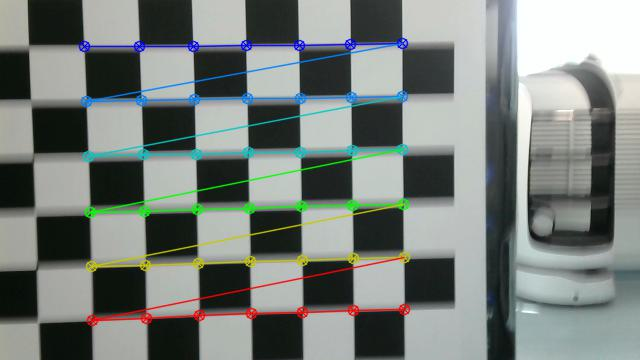

48

In [12]:
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, IMAGE_SHAPE[1])
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, IMAGE_SHAPE[0])

d0 = IPython.display.display(None, display_id=1)
d1 = IPython.display.display(None, display_id=2)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

fps = 15.0

i = 0
t0 = time.time()  

found = True

while True: 
    try:
        
        if time.time() - t0 > 1/fps:
            t0 = time.time()   
            
            ret, frame = cam.read()
            
            if not ret or frame is None:
                continue    
                
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
            if ret == True:
                corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
                cv2.drawChessboardCorners(frame, (7,6), corners2, ret)
                found = True            

            d0.update( array_to_image(frame) )
            d1.update( i )
            
            if found:
                cv2.imwrite("data/%d.jpg" % i, img)
                time.sleep(1)
                found = False
                i+=1
    
          
    except KeyboardInterrupt:
        break
    except Exception as e:
        cam.release()
        raise e
cam.release()

### Calibration

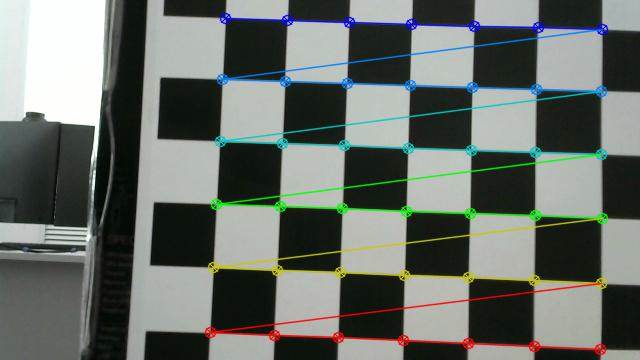

In [89]:
d2 = IPython.display.display(None, display_id=3)

# ---- termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# ---- prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# ---- Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('data/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # ---- Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # ---- If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # ---- Draw and display the corners
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
#         cv.imshow('img', img)
#         cv.waitKey(500)
        d2.update( array_to_image(img) )
        time.sleep(0.2)
        
# cv.destroyAllWindows()

In [99]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#### Save parameters to pickle

In [94]:
import codecs, json, os 

calibration_params = {
    'ret': ret, 
    'mtx': mtx.tolist(), 
    'dist': dist.tolist(), 
    'rvecs': [rvec.tolist() for rvec in rvecs], 
    'tvecs': [tvec.tolist() for tvec in tvecs]
}
file_path = "./calibration/calibration_params.json"

json.dump(
    calibration_params, 
    codecs.open(file_path, 'w', encoding='utf-8'), 
    separators=(',', ':'), 
    sort_keys=True, 
    indent=4
)

print('Camera calibration parameters are in "%s"' % os.path.abspath(file_path))


Camera calibration parameters are in "/home/user/Projects/GLK/calibration/calibration_params.json"


#### Load calib parameters

In [95]:
calibration_params_path = 'calibration/calibration_params.json'
obj_text = codecs.open(calibration_params_path, 'r', encoding='utf-8').read()
calibration_params = json.loads(obj_text)

ret, mtx, dist, rvecs, tvecs = calibration_params['ret'], np.asarray(calibration_params['mtx']), np.asarray(calibration_params['dist']), calibration_params['rvecs'], calibration_params['tvecs']
camera_matrix, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

### Undistort

In [100]:
img = cv2.imread('../../Downloads/chessboard.jpg')
img = cv2.resize(img, IMAGE_SHAPE[:2][::-1])

h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# ---- undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx) 

# ---- crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
dst = cv.resize(dst, IMAGE_SHAPE[:2][::-1])
# cv.imwrite('calibresult.png', dst)

array_to_image(dst)
# array_to_image(img)
cv.imwrite('calibresult.png', dst)

True

In [101]:
# ---- undistort
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, img.shape[:2], 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
# ---- crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
dst = cv.resize(dst, IMAGE_SHAPE[:2][::-1])
# cv.imwrite('calibresult.png', dst)

array_to_image(dst)
# array_to_image(img)
cv.imwrite('calibresult1.png', dst)


True

In [88]:
1

1

In [102]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.05369985967064379
